In [ ]:
#| default_exp core 

In [ ]:
from fastcore.utils import *
import fastcore.all as fc, re, math, itertools, functools, numpy as np, types, typing, dataclasses, matplotlib.pyplot as plt, collections, regex
from fastcore.xtras import dict2obj
from regex import search
from collections import Counter
from collections.abc import Iterable
from httpx import get as xget, post as xpost
from fasthtml.common import *
from monsterui.core import *
np.set_printoptions(linewidth=150, suppress=True)
plt.rcParams['figure.dpi'] = 50

from dotenv import load_dotenv

from base64 import b64decode
from ipykernel_helper import get_md
from IPython.display import Image, display


In [ ]:
#| export
import os
from time import time
from fastcore.utils import patch
from fastcore.xtras import dict2obj
from httpx import get as xget, post as xpost

In [ ]:

load_dotenv()

True

Hi solveit! I am Pol, and I am working with you today! I'm an experienced Python coder and I enjoy learning new things. When writing code for me, please follow fast.ai coding style: avoid comments; place single line if/loop/etc constructs on the same line; use concise variable names where appropriate. Follow the style you will see in my messages, as we work on this dialogue together. Are you ready?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Hi Pol! Yes, I'm absolutely ready to work with you! I'm familiar with the fast.ai coding style and will follow your preferences for concise, clear code without unnecessary comments. I see you've already set up some useful imports including fastcore, which I know is central to the fast.ai approach.



The goal of this notebook is to set up communication with my home thermostat from the Netatmo brand. I have already created an app on their website to get API access.

The documentation is here: https://dev.netatmo.com/apidocumentation/general

The documentation pages are rendered using JS so let's first set up Zyte so we can render those pages and access the proper docs.

## Zyte API

In [ ]:
def fetch_page(
    url:str, # URL to fetch,
    browser_html:bool=True, # Use a browser to reunder js page?
    as_md:bool=False, # Convert HTML to markdown?
    screenshot:bool=False, # Also return a screenshot?
    timeout:int=15, # fetch timeout in seconds
):
    "Fetch a page"
    api_key=os.getenv('ZYTE_API_KEY')
    r = xpost("https://api.zyte.com/v1/extract", auth=(api_key, ""), json=dict(url=url, browserHtml=browser_html, screenshot=screenshot), timeout=timeout)
    r.raise_for_status()
    rj = r.json()
    if rj['statusCode'] != 200: raise Exception(f"Status {rj['statusCode']} for {url}")
    html = get_md(rj['browserHtml']) if as_md else rj['browserHtml']
    img = Image(data=b64decode(rj['screenshot'])) if screenshot and 'screenshot' in rj else None
    return (html, img) if screenshot else html

In [ ]:
html, img = fetch_page('https://dev.netatmo.com/apidocumentation/energy', screenshot=True)

In [ ]:
html[:500]

'<!DOCTYPE html><html><head>\n    <meta data-n-head="ssr" charset="utf-8"><meta data-n-head="ssr" name="viewport" content="width=device-width, initial-scale=1"><meta data-n-head="ssr" data-hid="description" name="description" content="We want to create a smarter home. With Netatmo connect, creative people can imagine solutions to make users\' life easier.\n                Netatmo products are ready to communicate with all Apps and services to fit your vision of what makes a home smarter."><meta data'

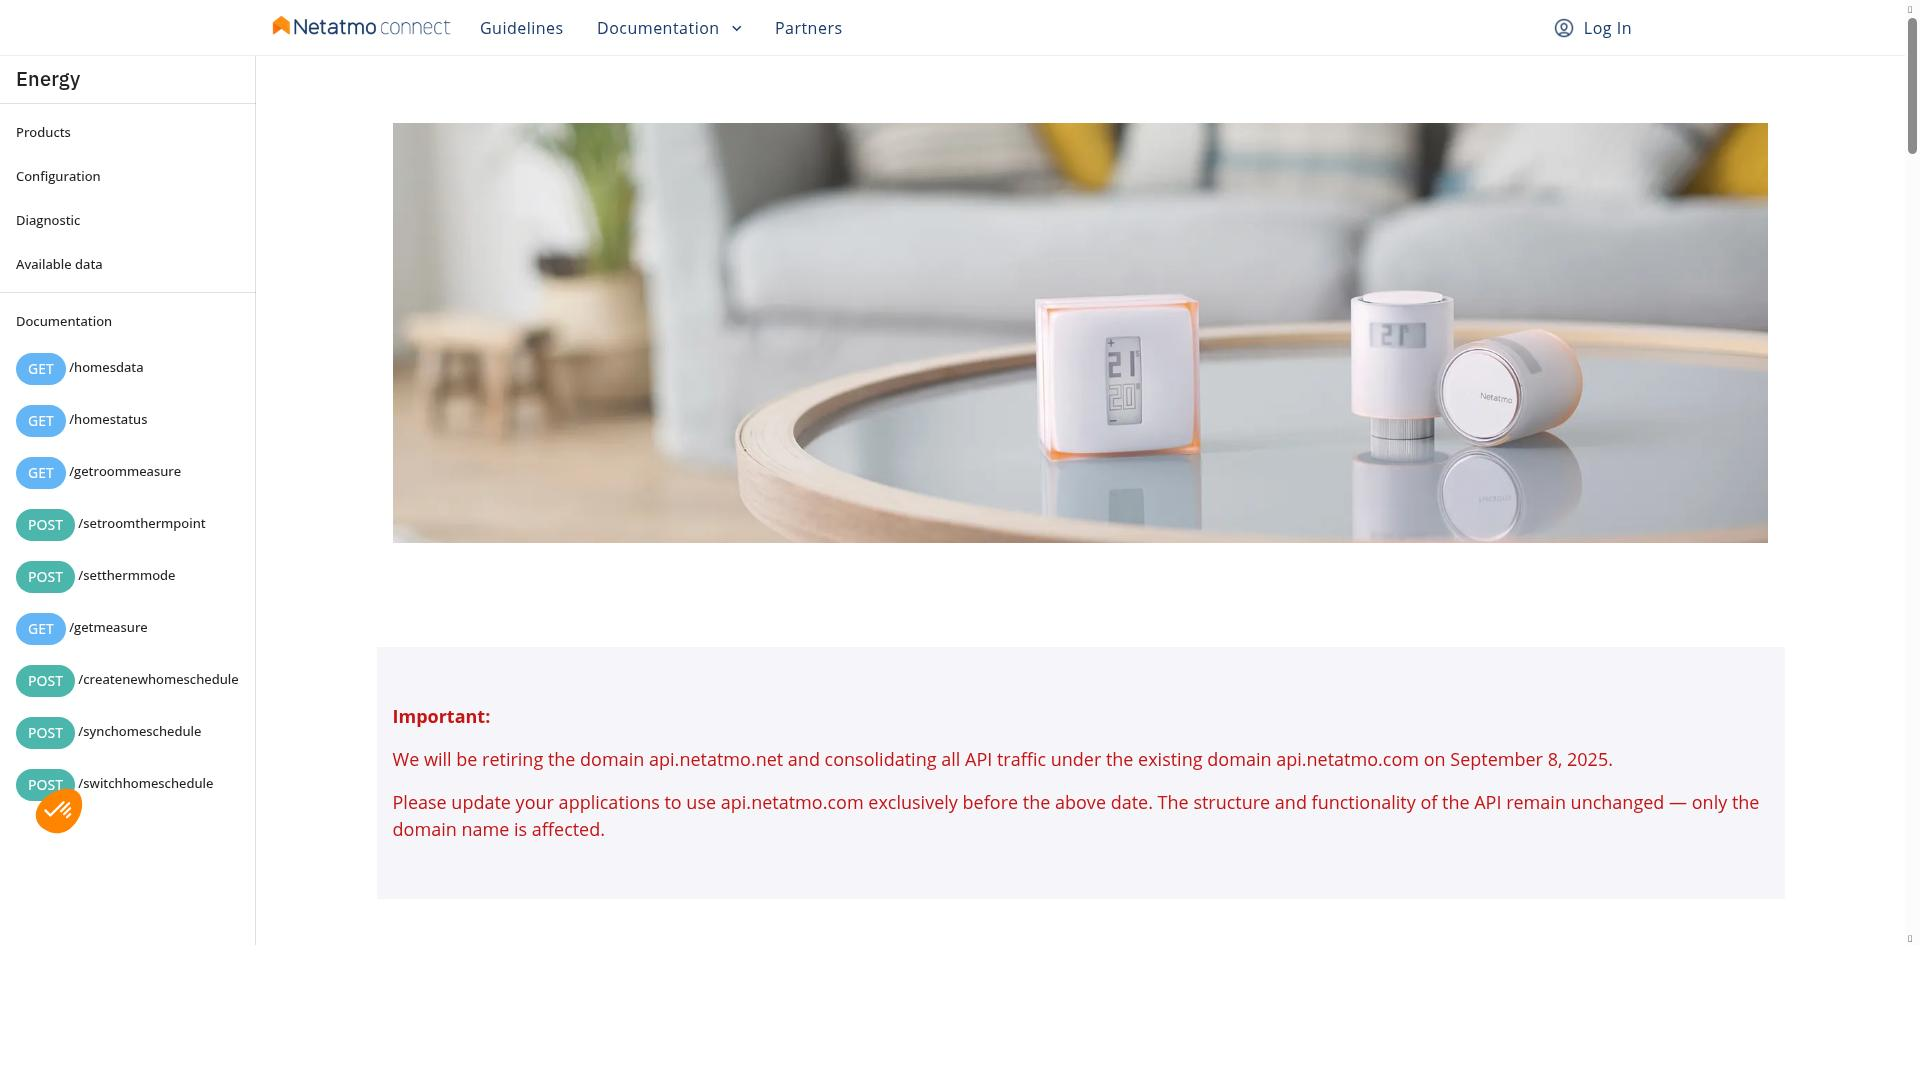

In [ ]:
img

## Thermostat Class

Can you use the & `fetch_page` to navigate the netatmo docs and list the endpoints available?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01D6hiFiSfPzjt2ae9LgebJ4",
  "call": {
    "function": "fetch_page",
    "arguments": {
      "url": "https://dev.netatmo.com/apidocumentation/energy",
      "as_md": "True"
    }
  },
  "result": "\"[![Netatmo Connect](https://medias.netatmo.com/images/logos/netatmo-connect/:/rs=h:60)](/)\\n\\n[ Guidelines ](/guideline)\\n\\n[ Documentation __](/apidocumentation)[Partners](/business-showcase)\\n\\n![Log in](https://medias.netatmo.com/images/icons/account) log in \\n\\n![](https://medias.netatmo.com/images/energy/landing-nth-nav)\\n\\n**Important:**\\n\\nWe will be retiring the domain api.netatmo.net and consolidating all API traffic under the existing domain api.netatmo.com on September 8, 2025.\\n\\nPlease update your applications to use api.netatmo.com exclusively before the above date. The structur<TRUNCATED>"
}
```

</details>

Here are the **Energy API endpoints** for your Netatmo thermostat:

| Method | Endpoint | Description |
|--------|----------|-------------|
| GET | `/homesdata` | Retrieve user's homes and topology |
| GET | `/homestatus` | Get current status of home and devices |
| GET | `/getroommeasure` | Retrieve room data history (for graphs) |
| POST | `/setroomthermpoint` | Control heating of a room |
| POST | `/setthermmode` | Control home heating system |
| GET | `/getmeasure` | Retrieve boiler historical data |
| POST | `/createnewhomeschedule` | Create thermostat weekly schedule |
| POST | `/synchomeschedule` | Modify thermostat weekly schedule |
| POST | `/switchhomeschedule` | Apply a specific schedule |

Base domain is `api.netatmo.com` (they're retiring `api.netatmo.net` on Sept 8, 2025).

Want me to fetch more details on any specific endpoint, or shall we look at authentication first?

**Energy API endpoints** for Netatmo thermostat:

| Method | Endpoint | Description |
|--------|----------|-------------|
| GET | `/homesdata` | Retrieve user's homes and topology |
| GET | `/homestatus` | Get current status of home and devices |
| GET | `/getroommeasure` | Retrieve room data history (for graphs) |
| POST | `/setroomthermpoint` | Control heating of a room |
| POST | `/setthermmode` | Control home heating system |
| GET | `/getmeasure` | Retrieve boiler historical data |
| POST | `/createnewhomeschedule` | Create thermostat weekly schedule |
| POST | `/synchomeschedule` | Modify thermostat weekly schedule |
| POST | `/switchhomeschedule` | Apply a specific schedule |

Base domain is `api.netatmo.com` (they're retiring `api.netatmo.net` on Sept 8, 2025).


In [ ]:
#| export
class Thermostat:
    base = 'https://api.netatmo.com'
    
    def __init__(self, client_id=None, client_secret=None, access_token=None, refresh_token=None):
        self.client_id = client_id or os.getenv('CLIENT_ID')
        self.client_secret = client_secret or os.getenv('CLIENT_SECRET')
        self.access_token = access_token or os.getenv('ACCESS_TOKEN')
        self.refresh_token = refresh_token or os.getenv('REFRESH_TOKEN')

In [ ]:
t = Thermostat()
t.client_id[:10]  # quick check

'6952046932'

In [ ]:
#| export
@patch
def _refresh(self:Thermostat):
    r = xpost(f'{self.base}/oauth2/token', data={
        'grant_type': 'refresh_token',
        'refresh_token': self.refresh_token,
        'client_id': self.client_id,
        'client_secret': self.client_secret
    })
    d = r.json()
    self.access_token, self.refresh_token = d['access_token'], d['refresh_token']
    return d

In [ ]:
r = t._refresh()
list(r)

['access_token', 'refresh_token', 'expires_in', 'expire_in', 'scope']

In [ ]:
#| export
@patch
def _request(self:Thermostat,
    endpoint:str, # the endpoint to query
    method='post', # the http method,
    **kwargs
): # extra kwargs
    "Request a Netatmo API endpoint with auto-refresh on expired token."

    url = f'{self.base}/api/{endpoint}'
    headers = kwargs.pop('headers', {})
    headers['Authorization'] = f'Bearer {self.access_token}'
    
    r = xpost(url, headers=headers, **kwargs) if method == 'post' else xget(url, headers=headers, **kwargs)
    if r.status_code in (401, 403): 
        self._refresh()
        return self._request(endpoint, method, **kwargs)
    rj = r.json()
    return dict2obj(rj.get('body', rj))


In [ ]:
from dialoghelper.core import *

# tool_info()

Tools available from dialoghelper: &`[curr_dialog, msg_idx, add_html, find_msg_id, find_msgs, read_msg, del_msg, add_msg, update_msg, msg_insert_line, msg_str_replace, msg_strs_replace, msg_replace_lines]`

### Homes data

In [ ]:
#| export
@patch
def homesdata(self:Thermostat):
    return self._request('homesdata')

In [ ]:
r = t.homesdata()
home_id = r.homes[0].id
home_id

'693572355b98bfc2a009b174'

In [ ]:
r.homes[0].schedules


(#1) [{'timetable': [{'zone_id': 1, 'm_offset': 0}, {'zone_id': 0, 'm_offset': 480}, {'zone_id': 1, 'm_offset': 1440}, {'zone_id': 0, 'm_offset': 1920}, {'zone_id': 1, 'm_offset': 2880}, {'zone_id': 0, 'm_offset': 3360}, {'zone_id': 1, 'm_offset': 4320}, {'zone_id': 0, 'm_offset': 4800}, {'zone_id': 1, 'm_offset': 5760}, {'zone_id': 0, 'm_offset': 6240}, {'zone_id': 1, 'm_offset': 7200}, {'zone_id': 0, 'm_offset': 7740}, {'zone_id': 1, 'm_offset': 8640}, {'zone_id': 0, 'm_offset': 9180}], 'zones': [{'name': 'Night', 'id': 1, 'type': 1, 'rooms_temp': [{'room_id': '3352988001', 'temp': 21}], 'modules': [], 'rooms': [{'id': '3352988001', 'therm_setpoint_temperature': 21}]}, {'name': 'Comfort', 'id': 0, 'type': 0, 'rooms_temp': [{'room_id': '3352988001', 'temp': 21}], 'modules': [], 'rooms': [{'id': '3352988001', 'therm_setpoint_temperature': 21}]}, {'name': 'Comfort +', 'id': 3, 'type': 8, 'rooms_temp': [{'room_id': '3352988001', 'temp': 22}], 'modules': [], 'rooms': [{'id': '3352988001',

We can see one schedule called "Temperature schedule" with:

**Zones** (temperature presets):
- `Night` (id 1): 21°C
- `Comfort` (id 0): 21°C  
- `Comfort +` (id 3): 22°C
- `Eco` (id 4): 19°C

**Timetable** - `m_offset` is minutes from Monday 00:00:
- `0` = Mon 00:00 → zone 1 (Night)
- `480` = Mon 08:00 → zone 0 (Comfort)
- `1440` = Tue 00:00 → zone 1 (Night)
- etc.

**Special temps:**
- `away_temp`: 17°C
- `hg_temp`: 7°C (frost guard)

So it switches between Night and Comfort zones each day at midnight and 8am

### Home status

In [ ]:
#| export
@patch
def homestatus(self:Thermostat, home_id): return self._request('homestatus', data={'home_id': home_id})

In [ ]:
st = t.homestatus(home_id=home_id)
room = st.home.rooms[0]
room

```python
{ 'anticipating': False,
  'heating_power_request': 0,
  'id': '3352988001',
  'open_window': False,
  'reachable': True,
  'therm_measured_temperature': 18.6,
  'therm_setpoint_mode': 'off',
  'therm_setpoint_start_time': 1767067816,
  'therm_setpoint_temperature': 0}
```

#| export
can you now create the following method from the endpoints list? use my same format, begin with header section with the name, add a patch, and display the results. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Which endpoint would you like to add first? Options from the list:

- `getroommeasure` - historical room data
- `setroomthermpoint` - set room temperature
- `setthermmode` - set home mode (schedule/away/hg)
- `getmeasure` - boiler history
- `createnewhomeschedule` - create schedule
- `synchomeschedule` - modify schedule
- `switchhomeschedule` - switch active schedule

let's do them all in order, first only getroommeasuer

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01HunczNpfbgMrcgkYhKt9EF",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### Getroommeasure"
    }
  },
  "result": "'_5dcdeea5'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Un5xyQRYNUejKCYZCTnrYc",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef getroommeasure(self:Thermostat, home_id, room_id, scale='1hour', type='temperature', begin=None, end=None):\n    return self._request('getroommeasure', data=fc.dict_filter(\n        {'home_id': home_id, 'room_id': room_id, 'scale': scale, 'type': type, 'date_begin': begin, 'date_end': end}))"
    }
  },
  "result": "'_3eb95a1f'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01VuX3fqR4a6YEAmdjv4oDWT",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "t.getroommeasure(home_id, room.id)"
    }
  },
  "result": "'_50cb2c7a'"
}
```

</details>

Done! I've added the `getroommeasure` method. Run those cells and let me know what you get back — the `type` param can be `'temperature'` or `'sp_temperature'` (setpoint), and `scale` can be `'30min'`, `'1hour'`, `'3hours'`, `'1day'`, `'1week'`, `'1month'`.

### Get room measure

In [ ]:
#| export
@patch
def getroommeasure(self:Thermostat,
    home_id:str,   # Home ID
    room_id:str,   # Room ID
    scale:str='1hour',  # Time scale: 30min, 1hour, 3hours, 1day, 1week, 1month
    type:str='temperature',  # Data type: temperature or sp_temperature
    begin:int=None,  # Start timestamp
    end:int=None,    # End timestamp
):
    "Retrieve room temperature history"
    d = {'home_id': home_id, 'room_id': room_id, 'scale': scale, 'type': type}
    if begin: d['date_begin'] = begin
    if end: d['date_end'] = end
    return self._request('getroommeasure', data=d)

In [ ]:
r = t.getroommeasure(home_id, room.id)
list(r)

[{'beg_time': 1765110600,
  'step_time': 3600,
  'value': (#544) [[22.2],[22.2],[22.1],[22],[22.1],[22.3],[22.9],[22.7],[22.3],[22],[22],[21.9],[21.3],[21.1],[21],[21],[21],[21.1],[21.3],[21.7]...]}]

let's do a super minimal plot of the data

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠

```python
plt.plot(r[0]['value'])
```

[<matplotlib.lines.Line2D>]

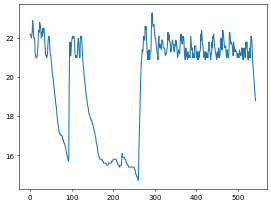

In [ ]:
plt.plot([v[0] for v in r[0]['value']])

amazing! let's do the next endpoint

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Rn74vzg44TKw4nVfbhD6hg",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### setroomthermpoint"
    }
  },
  "result": "'_f48d7b2e'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01SSUKm8ojetBtSx4g3cJXcB",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef setroomthermpoint(self:Thermostat,\n    home_id:str,   # Home ID\n    room_id:str,   # Room ID\n    mode:str,      # Mode: manual, home, or schedule\n    temp:float=None,      # Target temperature (for manual mode)\n    endtime:int=None,     # End timestamp (for manual mode)\n):\n    \"Set room temperature setpoint\"\n    d = {'home_id': home_id, 'room_id': room_id, 'mode': mode}\n    if temp: d['temp'] = temp\n    if endtime: d['endtime'] = endtime\n    return self._request('setroomthermpoint', data=d)"
    }
  },
  "result": "'_f2a8da99'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_014hxrqjtoCkPhe39bHg6yr8",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "# Example: set room to 20\u00b0C for 1 hour\n# t.setroomthermpoint(home_id, room.id, mode='manual', temp=20, endtime=int(time.time())+3600)"
    }
  },
  "result": "'_f1dd2356'"
}
```

</details>

Done! I commented out the example since it would actually change your thermostat. Run the first cell to add the method, then you can test it when ready. Next up is `setthermmode`?

maybe let's first get the therm point so then we can actually set and unset it to make sure this works

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You already have the setpoint from `homestatus` — check `room`:

```python
room.therm_setpoint_temperature, room.therm_setpoint_mode
```

That will show current temp and mode. Then you can set it, call `homestatus` again, and verify it changed.

### Set room therm point

In [ ]:
#| export
@patch
def setroomthermpoint(self:Thermostat,
    home_id:str,   # Home ID
    room_id:str,   # Room ID
    mode:str,      # Mode: manual, home, or schedule
    temp:float=None,      # Target temperature (for manual mode)
    endtime:int=None,     # End timestamp (for manual mode)
):
    "Set room temperature setpoint"
    d = {'home_id': home_id, 'room_id': room_id, 'mode': mode}
    if temp: d['temp'] = temp
    if endtime: d['endtime'] = endtime
    return self._request('setroomthermpoint', data=d)

@patch
def room_temperatures(self:Thermostat, home_id: str):
    "Nicer way to get a list of the temperatures of all room in the home"
    st = self.homestatus(home_id)
    return [dict(room_id=r.id, temperature=r.therm_measured_temperature, setpoint=r.therm_setpoint_temperature, setpoint_mode=r.therm_setpoint_mode) for r in st.home.rooms]

In [ ]:
# let's check the thermp point before setting it

t.room_temperatures(home_id)


[{'room_id': '3352988001',
  'temperature': 18.6,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

In [ ]:
# Example: set room to 20°C for 1 hour
t.setroomthermpoint(home_id, room.id, mode='manual', temp=20, endtime=int(time())+3600)

```python
{'status': 'ok', 'time_server': 1767067846}
```

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 18.6,
  'setpoint': 20,
  'setpoint_mode': 'manual'}]

We can see the thermostat was turned on, let's turn it off again below

In [ ]:
t.setroomthermpoint(home_id, room.id, mode='off')

```python
{'status': 'ok', 'time_server': 1767067847}
```

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 18.6,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

amazing! let's do another method

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01XDjLFWZHzxkWjqjH6jk2zx",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### setthermmode"
    }
  },
  "result": "'_be102f56'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_017ts9PKjZtrtTrBa548vWcr",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef setthermmode(self:Thermostat,\n    home_id:str,   # Home ID\n    mode:str,      # Mode: schedule, away, hg (frost guard)\n    endtime:int=None,  # End timestamp (for away/hg modes)\n):\n    \"Set home thermostat mode\"\n    d = {'home_id': home_id, 'mode': mode}\n    if endtime: d['endtime'] = endtime\n    return self._request('setthermmode', data=d)"
    }
  },
  "result": "'_e51c0227'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01GemP1TdjJUNwwGxTtBJ22q",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "# t.setthermmode(home_id, mode='schedule')"
    }
  },
  "result": "'_ce3bf4ca'"
}
```

</details>

Done! Modes are `schedule` (follow weekly schedule), `away` (away mode), and `hg` (frost guard/minimum temp). Next is `getmeasure` for boiler history?

### Set therm mode

In [ ]:
#| export
@patch
def setthermmode(self:Thermostat,
    home_id:str,   # Home ID
    mode:str,      # Mode: schedule (weekly program), away (reduced temp), hg (frost guard ~7°C)
    endtime:int=None,  # End timestamp (for away/hg modes)
):
    "Set home thermostat mode"
    d = {'home_id': home_id, 'mode': mode}
    if endtime: d['endtime'] = endtime
    return self._request('setthermmode', data=d)

I think it would be good to document a bit more the schedule modes, should we add the info after the markdown header? or in the method docstring or docments? wdyt?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'd suggest in the docments (the parameter comments) since that's where you already have the pattern and it keeps info close to the code. Something like:

```python
mode:str,      # Mode: schedule (weekly), away (reduced temp), hg (frost guard ~7°C)
```

Or if you want more detail, a short note after the header works too. What's your preference?

docments sounds good! do it for me please!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_015oE9j2k2QJjddhRMibEcMv",
  "call": {
    "function": "msg_str_replace",
    "arguments": {
      "msgid": "_e51c0227",
      "old_str": "mode:str,      # Mode: schedule, away, hg (frost guard)",
      "new_str": "mode:str,      # Mode: schedule (weekly program), away (reduced temp), hg (frost guard ~7\u00b0C)"
    }
  },
  "result": "{'success': 'Replaced text in message _e51c0227'}"
}
```

</details>

Done! Updated the `mode` docment with more detail.

In [ ]:
# t.setthermmode(home_id, mode='schedule')

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 18.6,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

is this what we expect after setting the mode to schedule?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, this looks correct! `setthermmode` sets the *home's* operating mode to follow the schedule, but the schedule itself currently has your room set to "off" at this time of day. So the room's `setpoint_mode: 'off'` is what the schedule dictates right now.

If you had heating periods defined in your weekly schedule, the room would show `setpoint_mode: 'schedule'` with a target temperature during those times.

can you explain this a bit in a note so users reading my notebook will get it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KyVTw3dm44x9wNpWxtDya4",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "**Note:** `setthermmode` controls the *home's* operating mode (schedule/away/hg), not individual room setpoints. When set to `schedule`, each room follows its weekly program\u2014so a room showing `setpoint_mode: 'off'` means the schedule has it off at that time. During scheduled heating periods, it would show `setpoint_mode: 'schedule'` with a target temperature."
    }
  },
  "result": "'_42759b01'"
}
```

</details>

Done! Want to continue with `getmeasure` next?

**Note:** `setthermmode` controls the *home's* operating mode (schedule/away/hg), not individual room setpoints. When set to `schedule`, each room follows its weekly program—so a room showing `setpoint_mode: 'off'` means the schedule has it off at that time. During scheduled heating periods, it would show `setpoint_mode: 'schedule'` with a target temperature.

### Get measure

In [ ]:
#| export
@patch
def getmeasure(self:Thermostat,
    device_id:str,     # Device MAC address
    module_id:str=None,  # Module MAC (if reading from a module)
    scale:str='1hour', # Time scale: 30min, 1hour, 3hours, 1day, 1week, 1month
    type:str='boileron',  # Data type: boileron, boileroff, sum_boiler_on, sum_boiler_off
    begin:int=None,    # Start timestamp
    end:int=None,      # End timestamp
):
    "Retrieve boiler historical data"
    d = {'device_id': device_id, 'scale': scale, 'type': type}
    if module_id: d['module_id'] = module_id
    if begin: d['date_begin'] = begin
    if end: d['date_end'] = end
    return self._request('getmeasure', data=d)

In [ ]:
# Get device_id from homesdata
r = t.homesdata()
device_id = r.homes[0].modules[0].id
m = t.getmeasure(device_id)
list(m)

[{'beg_time': 1765110600,
  'step_time': 3600,
  'value': (#544) [[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]...]}]

I don't have a boiler device so the data is None

I assumed it's none because I have no boiler, but then I actually have a device_id, what's that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! The `device_id` is likely your thermostat or relay module, not a boiler. Try checking what modules you have:

```python
[(m.id, m.type, m.get('name', '')) for m in r.homes[0].modules]
```

This will show you what devices are registered. The `getmeasure` endpoint specifically tracks boiler on/off times, which requires a compatible boiler controller module to report that data.

In [ ]:
[(m.type, m.get('name', '')) for m in r.homes[0].modules]

[('NAPlug', 'Termostato'), ('NATherm1', 'Thermostat')]

.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You have:
- **NAPlug** - the relay that controls heating on/off
- **NATherm1** - the thermostat that measures temperature and sends commands

The `getmeasure` boiler data likely returns `None` because your relay isn't logging boiler cycles, or your heating system doesn't report that info. This is normal for many setups.

Ready for the next endpoint? We have `createnewhomeschedule`, `synchomeschedule`, and `switchhomeschedule` left.

### Create new home schedule

In [ ]:
#| export
@patch
def createnewhomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    name:str,          # New schedule name
    zones:list,        # List of zone dicts with id, name, type, rooms_temp
    timetable:list,    # List of timetable entries with zone_id, m_offset
    hg_temp:float=7,   # Frost guard temp
    away_temp:float=17, # Away mode temp
):
    "Create a new weekly schedule"
    return self._request('createnewhomeschedule', data={
        'home_id': home_id, 'name': name, 'zones': zones, 
        'timetable': timetable, 'hg_temp': hg_temp, 'away_temp': away_temp})

### Switch home schedule

In [ ]:
#| export
@patch
def switchhomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    schedule_id:str,   # Schedule ID to activate
):
    "Switch to a specific weekly schedule"
    return self._request('switchhomeschedule', data={'home_id': home_id, 'schedule_id': schedule_id})

### Sync home schedule

In [ ]:
#| export
@patch
def synchomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    schedule_id:str,   # Schedule ID to modify
    zones:list,        # List of zone dicts with id, name, type, rooms_temp
    timetable:list,    # List of timetable entries with zone_id, m_offset
    name:str=None,     # Schedule name
    hg_temp:float=None,   # Frost guard temp
    away_temp:float=None, # Away mode temp
):
    "Modify an existing weekly schedule"
    d = {'home_id': home_id, 'schedule_id': schedule_id, 'zones': zones, 'timetable': timetable}
    if name: d['name'] = name
    if hg_temp: d['hg_temp'] = hg_temp
    if away_temp: d['away_temp'] = away_temp
    return self._request('synchomeschedule', data=d)

## Publishing the package to pypi

is our SDK only for thermostats? I'm planning to make it publicly available and I'm wondering what the github repo name and description should be to make it easily discoverable

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Currently yes — we've only implemented the Energy API endpoints (thermostats/heating). Netatmo also has APIs for:
- **Weather** - weather stations, rain gauges
- **Security** - cameras, smoke detectors
- **Aircare** - air quality monitors

Naming options:
1. **Thermostat-specific**: `netatmo-thermostat`, `netatmo-energy-py` — clear but limited scope
2. **Expandable**: `netatmo-py`, `python-netatmo` — room to grow if you add other products later

For discoverability, I'd suggest `netatmo-py` or `netatmo-api-python` with a description like "Python SDK for Netatmo APIs (Energy/Thermostat)" — accurate now but leaves room to expand.

What's your preference?

I don't want to spend too much time on it, but would be great to publish it and maybe tweet it? It is basically a "reply" to this tweet by Andrej Karpathy:
```
I was inspired by this so I wanted to see if Claude Code can get into my Lutron home automation system.

- it found my Lutron controllers on the local wifi network
- checked for open ports, connected, got some metadata and identified the devices and their firmware
- searched the internet, found the pdf for my system
- instructed me on what button to press to pair and get the certificates
- it connected to the system and found all the home devices (lights, shades, HVAC temperature control, motion sensors etc.)
- it turned on and off my kitchen lights to check that things are working (lol!)

I am now vibe coding the home automation master command center, the potential is 🔥.And I'm throwing away the crappy, janky, slow Lutron iOS app I've been using so far. Insanely fun :D :D
```
I then did this:
```
I tried this too by asking CC to connect to my netatmo thermostat.

CC spent a huge amount of tokens scanning ports, using nmap, arp, dsn, web searching for my thermostat's brand MAC prefix, etc...

It did find my thermostat MAC address, which looked cool. Later, it walked me through the official way of creating an 'App' in the netatmo and getting the keys & tokens.

At this point the whole message quota almost ran out. 

Then it hit me that I was just going to use their standard API, so why the MAC and all that stuff. Effectively, all that exploration is pretty useless as CC recognizes, just a token sink.


It would have been much quicker to have a look at the docs from the beginning and set a quick python script to try it out.

It feels kind of useless to have wasted this amount of tokens for nothing, on the other hand, it's true that I would never have thought of trying to use my thermostat with an API (I have a perfectly ok app to do so) w/o CC, both because the original tweet was caused by CC and because I could just spin it up on the background while I did other stuff.

Bittersweet.
```

So I decided to do it the solveIT way

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great story! The contrast is compelling: CC burned tokens on exploratory scanning while the solveit approach went straight to docs → working SDK in a focused session.

For sharing, you could:

1. **Export this notebook** as a GitHub gist or repo with a simple README telling the story
2. **Tweet thread**: Your existing text is already good — just add a link to the notebook and maybe a screenshot of the temperature plot

Repo name suggestion: `netatmo-solveit` or `netatmo-the-boring-way` 😄

Want help drafting a README or tweet thread?

yes create a basic README explaining how to use it. Consider that we will export all the important class methods into a .py file to be used

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01T5Z7MdaZ3af1ibUnAVreXH",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "# netatmo-energy\n\nA simple Python SDK for the Netatmo Energy API (thermostats).\n\n## Setup\n\n1. Create an app at [dev.netatmo.com](https://dev.netatmo.com) to get your API credentials\n2. Create a `.env` file:\n```\nCLIENT_ID=your_client_id\nCLIENT_SECRET=your_client_secret\nACCESS_TOKEN=your_access_token\nREFRESH_TOKEN=your_refresh_token\n```\n\n## Usage\n\n```python\nfrom netatmo import Thermostat\n\nt = Thermostat()\nhomes = t.homesdata()\nhome_id = homes.homes[0].id\n\n# Get current status\nt.room_temperatures(home_id)\n\n# Set room to 20\u00b0C for 1 hour\nt.setroomthermpoint(home_id, room_id, mode='manual', temp=20,<TRUNCATED>"
    }
  },
  "result": "'_0bcdb02f'"
}
```

</details>

Done! Take a look and let me know if you want any changes — I can adjust the tone, add more detail to any section, or link to Karpathy's actual tweet URL if you have it.

# netatmo-energy

A simple Python SDK for the Netatmo Energy API (thermostats).

## Setup

1. Create an app at [dev.netatmo.com](https://dev.netatmo.com) to get your API credentials
2. Create a `.env` file:
```
CLIENT_ID=your_client_id
CLIENT_SECRET=your_client_secret
ACCESS_TOKEN=your_access_token
REFRESH_TOKEN=your_refresh_token
```

## Usage

```python
from netatmo import Thermostat

t = Thermostat()
homes = t.homesdata()
home_id = homes.homes[0].id

# Get current status
t.room_temperatures(home_id)

# Set room to 20°C for 1 hour
t.setroomthermpoint(home_id, room_id, mode='manual', temp=20, endtime=int(time())+3600)

# Get temperature history
t.getroommeasure(home_id, room_id)
```

## Methods

- `homesdata()` — get homes and topology
- `homestatus(home_id)` — current device status
- `room_temperatures(home_id)` — quick view of all room temps
- `getroommeasure(home_id, room_id, ...)` — temperature history
- `setroomthermpoint(home_id, room_id, mode, ...)` — set room temperature
- `setthermmode(home_id, mode)` — set home mode (schedule/away/hg)
- `getmeasure(device_id, ...)` — boiler history
- `createnewhomeschedule(...)` — create weekly schedule
- `synchomeschedule(...)` — modify schedule
- `switchhomeschedule(home_id, schedule_id)` — activate schedule

## Background

Inspired by [Andrej Karpathy's tweet](https://x.com/karpathy) about using Claude Code for home automation. Instead of burning tokens on network scanning, this takes the "boring" approach: read the docs, write a simple SDK.

I just cloned the repo into our current working dir, I think the easiest to publish it is to set it up as an nbdev project, could you help with that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sure! Let's see what's in the repo first:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Mvo1jSv5gsRE7Xr6fh1WKU",
  "call": {
    "function": "view",
    "arguments": {
      "path": "."
    }
  },
  "result": "'Directory contents of /app/data/netatmo-thermostat:\\n/app/data/netatmo-thermostat/thermostat-netatmo.ipynb\\n/app/data/netatmo-thermostat/netatmo-thermostat\\n/app/data/netatmo-thermostat/thermostat_netatmo.py\\n/app/data/netatmo-thermostat/LICENSE'"
}
```

</details>

Got it. To set up nbdev, you'll need:

1. `settings.ini` - project config
2. `nbs/` folder for notebooks (or rename your existing one)
3. Run `nbdev_new` or create the config manually

Want me to create a minimal `settings.ini` for you, or would you prefer to run `nbdev_new` and configure interactively?

I already ran `nbdev_new` what next? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01En4683Nf9ArbRVut5Dfzvc",
  "call": {
    "function": "view",
    "arguments": {
      "path": "."
    }
  },
  "result": "'Directory contents of /app/<TRUNCATED>"
}
```

</details>

Good, nbdev scaffolding is there. Next steps:

1. Move your `Thermostat` code into `nbs/00_core.ipynb` with `#| export` directives
2. Update `nbs/index.ipynb` with your README content
3. Run `nbdev_export` to generate `netatmo_thermostat/core.py`

Want me to show you what the `#| export` cells should look like, or do you want to set that up yourself?

I marked the important cells for export already, can you now add at the top the nbdev header & explanation that usually begins with # default_exp ...

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01L7yd9a4SYQvzkHV9qPNyA2",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs/00_core.ipynb",
      "view_range": "[1, 30]"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/nbs/00_core.ipynb'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01XTLkEHUyCvsD7ydHk3D8KV",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/nbs'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01QmyU9icrqTChnZckbbRc9B",
  "call": {
    "function": "view",
    "arguments": {
      "path": "netatmo-thermostat"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/netatmo-thermostat'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_013GpeNz2ahBHX8kRBdRx47f",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat"
    }
  },
  "result": "'Directory contents of /app/<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01X1b3h9t6ALwFm44q8o5B3y",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/nbs/00_core.ipynb",
      "view_range": "[1, 40]"
    }
  },
  "result": "'{\\n \"cells\": [\\n  {\\n   \"cell_type\": \"code\",\\n   \"execution_count\": null,\\n   \"id\": \"e8cba711\",\\n   \"metadata\": {\\n    \"time_run\": \"2025-12-30T05:25:29.557629+00:00\"\\n   },\\n   \"outputs\": [],\\n   \"source\": [\\n    \"from fastcore.utils import *\\\\n\",\\n    \"import fastcore.all as fc, re, math, itertools, functools, numpy as np, types, typing, dataclasses, matplotlib.pyplot as plt, collections, regex\\\\n\",\\n    \"from fastcore.xtras import dict2obj\\\\n\",\\n    \"from regex import search\\\\n\",\\n    \"from collections import Counter\\\\n\",\\n    \"from collections.abc import Iterable\\\\n\",\\n    \"from httpx impo<TRUNCATED>"
}
```

</details>

I see the notebook already has `#| export` directives. The standard nbdev header goes at the very top. I'll add a new first cell with `#| default_exp core`:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01NWX5Y6WyQEJmoGzNF46T3o",
  "call": {
    "function": "insert",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/nbs/00_core.ipynb",
      "insert_line": "2",
      "new_str": "{\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"#| default_exp core\"]\n  },"
    }
  },
  "result": "'Inserted text at line 2 in /app/data/netatmo-thermostat/nbs/00_core.ipynb'"
}
```

</details>

Done! Added `#| default_exp core` as the first cell. Now `nbdev_export` will know to export marked cells to `netatmo_thermostat/core.py`.

great! I created the reamde with the appropriate content, anything left before pushing & publishing?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Quick checklist:

1. **Run `nbdev_export`** to generate the `.py` files
2. **Run `nbdev_clean`** to clean notebook metadata
3. **Check `settings.ini`** has correct: `lib_name`, `version`, `description`, `author`, `keywords`
4. **Test import**: `from netatmo_thermostat.core import Thermostat`

If those look good, you're ready to push and `nbdev_pypi`!

can you check the .py file to see if the imports I exported are correct and sufficient and whether settings.ini needs some package dependencies added?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_018acryaUaLZZEofKtARKtuw",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/netatmo_thermostat/core.py"
    }
  },
  "result": "'# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/00_core.ipynb.\\n\\n# %% auto 0\\n__all__ = [\\'Thermostat\\']\\n\\n# %% ../nbs/00_core.ipynb 2\\nimport os\\nfrom time import time\\nfrom fastcore.utils import patch\\nfrom fastcore.xtras import dict2obj\\nfrom httpx import get as xget, post as xpost\\n\\n# %% ../nbs/00_core.ipynb 15\\nclass Thermostat:\\n    base = \\'https://api.netatmo.com\\'\\n    \\n    def __init__(self):\\n        self.client_id = os.getenv(\\'CLIENT_ID\\')\\n        self.client_secret = os.getenv(\\'CLIENT_SECRET\\')\\n        self.access_token = os.getenv(\\'ACCESS_TOKEN\\')\\n        self.refre<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_013h6SPMxkjmSa1Db4LY8Hjh",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/settings.ini"
    }
  },
  "result": "'[DEFAULT]\\n# All sections below are required unless otherwise specified.\\n# See https://github.com/AnswerDotAI/nbdev/blob/main/settings.ini for examples.\\n\\n### Python library ###\\nrepo = netatmo-thermostat\\nlib_name = %(repo)s\\nversion = 0.0.1\\nmin_python = 3.9\\nlicense = apache2\\nblack_formatting = False\\n\\n### nbdev ###\\ndoc_path = _docs\\nlib_path = netatmo_thermostat\\nnbs_path = nbs\\nrecursive = True\\ntst_flags = notest\\nput_version_in_init = True\\nupdate_pyproject = True\\n\\n### Docs ###\\nbranch = main\\ncustom_sidebar = False\\ndoc_host = https://%(user)s.github.io\\ndoc_baseurl = /%(repo)s<TRUNCATED>"
}
```

</details>

Looks good! The imports use:
- `fastcore` (for `patch`, `dict2obj`)
- `httpx` (for API calls)

Your `settings.ini` already has `requirements = fastcore httpx` ✅

One thing missing: `getroommeasure` — I don't see it in the exported file. Did you mark that cell for export?

what is the `_proc` folder?

## UI

Amazing! now let's do a very basic FastHTML app that displays a beautiful historical plot of temperature vs. setpoint. Maybe we can start with the FastHTML component.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

For the plot, we could use either:
1. **Matplotlib** - generate a static image, serve as base64
2. **A JS charting lib** (like Chart.js or Plotly) - interactive, but more setup

Which approach would you prefer?

check FastHTML / monster.ui docs to see which charts they support and use one of those

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01DzuPzGs954Z8eUJDvjfVm4",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://monsterui.answer.ai/"
    }
  },
  "result": "'* Getting Started\\n    * Getting Started\\n    * Tutorial App\\n  * API Reference\\n    * Accordion | Link\\n    * Button | Link\\n    * Cards\\n    * Charts\\n    * Containers\\n    * Dividers\\n    * Forms\\n    * Html\\n    * Icons | Images\\n    * Layout\\n    * Lightbox\\n    * Lists\\n    * Loading\\n    * Markdown\\n    * Modals\\n    * Navigation\\n    * Notifications\\n    * Sliders\\n    * Steps\\n    * Tables\\n    * Theme | Headers\\n    * Typography\\n  * Guides\\n    * Spacing\\n    * Layout\\n  * Examples\\n    * Task\\n    * Card\\n    * Dashboard\\n    * Form\\n    * Music\\n    * Auth\\n    * Playground\\n    <TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01NBSYBGtVGwaHBs2Frqxpvv",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://monsterui.answer.ai/api_ref/charts"
    }
  },
  "result": "\"* Getting Started\\n    * Getting Started\\n    * Tutorial App\\n  * API Reference\\n    * Accordion | Link\\n    * Button | Link\\n    * Cards\\n    * Charts\\n    * Containers\\n    * Dividers\\n    * Forms\\n    * Html\\n    * Icons | Images\\n    * Layout\\n    * Lightbox\\n    * Lists\\n    * Loading\\n    * Markdown\\n    * Modals\\n    * Navigation\\n    * Notifications\\n    * Sliders\\n    * Steps\\n    * Tables\\n    * Theme | Headers\\n    * Typography\\n  * Guides\\n    * Spacing\\n    * Layout\\n  * Examples\\n    * Task\\n    * Card\\n    * Dashboard\\n    * Form\\n    * Music\\n    * Auth\\n    * Playground\\n    <TRUNCATED>"
}
```

</details>

[*](https://github.com/AnswerDotAI/MonsterUI/blob/main/monsterui/franken.py "MonsterUI/monsterui/franken.py at main · AnswerDotAI/MonsterUI") MonsterUI includes `ApexChart` for charting, which wraps the ApexCharts JavaScript library. [*](https://monsterui.answer.ai/dashboard/code "FastHTML page - MonsterUI") The dashboard example uses **Plotly Express** for line charts.

So you have two options:
1. **ApexChart** - built into MonsterUI (via `ApexChart(opts={...})`)  
2. **Plotly** - used in their dashboard example

Which would you prefer? ApexChart is lighter, Plotly is more feature-rich.

whatever is easier and more concise

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

ApexChart is simpler. Here's a basic line chart component:

```python
from monsterui.core import ApexChart

def temp_chart(temps, setpoints, times):
    return ApexChart(opts={
        'chart': {'type': 'line', 'height': 350},
        'series': [
            {'name': 'Temperature', 'data': temps},
            {'name': 'Setpoint', 'data': setpoints}
        ],
        'xaxis': {'categories': times}
    })
```

Want me to wire this up with your `getroommeasure` data?

In [ ]:
from monsterui.franken import ApexChart
from datetime import datetime

def temp_chart(temps, setpoints, times):
    return ApexChart(opts={
        'chart': {'type': 'line', 'height': 350},
        'series': [
            {'name': 'Temperature', 'data': temps},
            {'name': 'Setpoint', 'data': setpoints}
        ],
        'xaxis': {'categories': times}
    })

In [ ]:
# Get temp and setpoint history
temps_raw = t.getroommeasure(home_id, room.id, type='temperature')
sp_raw = t.getroommeasure(home_id, room.id, type='sp_temperature')

beg, step = temps_raw[0]['beg_time'], temps_raw[0]['step_time']
temps = [v[0] for v in temps_raw[0]['value']]
setpoints = [v[0] for v in sp_raw[0]['value']]
times = [datetime.fromtimestamp(beg + i*step).strftime('%m/%d %H:%M') for i in range(len(temps))]

In [ ]:
show(temp_chart(temps, setpoints, times))

I can't see the component, how to render it in notebook? I though fasthtml was auto-displayed, maybe it's the apex chart thing?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

ApexChart needs JavaScript to render, which doesn't work in notebook outputs. It's designed for FastHTML web apps.

For notebooks, stick with matplotlib:

```python
plt.figure(figsize=(12,4))
plt.plot(temps, label='Temperature')
plt.plot(setpoints, label='Setpoint')
plt.legend()
```

The ApexChart component will work once we build the actual FastHTML app. Want to set that up now?

<matplotlib.legend.Legend>

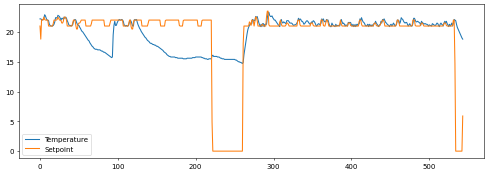

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(temps, label='Temperature')
plt.plot(setpoints, label='Setpoint')
plt.legend()

yes let's create the app now and run it from the notebook, you can see an example in: https://share.solve.it.com/d/60acda488c7dca4c931d4a4cd1a6481b

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01LVzsGQZM8U4bH6DpgcxXK1",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://share.solve.it.com/d/60acda488c7dca4c931d4a4cd1a6481b"
    }
  },
  "result": "'Try an interactive version of this dialog: Sign up at [solve.it.com](https://solve.it.com), click Upload, and pass this URL. \\n\\nCode: 225 ()\\n\\n[](/show_card_?msgid=_e8cba711&with_input=1&dlg_name=chinese%2Flookup)\\n```\\nfrom fastcore.utils import *\\nimport fastcore.all as fc, re, math, itertools, functools, numpy as np, types, typing, dataclasses, matplotlib.pyplot as plt, collections, regex\\nfrom fastcore.xtras import dict2obj\\nfrom regex import search\\nfrom collections import Counter\\nfrom collections.abc import Iterable\\nfrom httpx import get as xget, post as xpost\\nimport json\\n\\nfrom f<TRUNCATED>"
}
```

</details>

Got it. Here's the basic FastHTML app structure with your thermostat chart:

```python
from fasthtml.jupyter import *

app, rt = fast_app(hdrs=Theme.blue.headers())

@rt
def index():
    temps_raw = t.getroommeasure(home_id, room.id, type='temperature')
    sp_raw = t.getroommeasure(home_id, room.id, type='sp_temperature')
    beg, step = temps_raw[0]['beg_time'], temps_raw[0]['step_time']
    temps = [v[0] for v in temps_raw[0]['value']]
    setpoints = [v[0] for v in sp_raw[0]['value']]
    times = [datetime.fromtimestamp(beg + i*step).strftime('%m/%d %H:%M') for i in range(len(temps))]
    return Container(
        H1("Thermostat"),
        temp_chart(temps, setpoints, times)
    )

server = JupyUvi(app)
```

Run that, then `server.start()` to launch and `server.stop()` to stop. Does this look right to start with?

In [ ]:
from fasthtml.jupyter import *

app, rt = fast_app(hdrs=Theme.blue.headers())
if 'srv' in globals(): srv.stop()

In [ ]:
JupyUvi?

Init signature:
JupyUvi(
    app,
    log_level='error',
    host='0.0.0.0',
    port=8000,
    start=True,
    **kwargs,
)
Docstring:      Start and stop a Jupyter compatible uvicorn server with ASGI `app` on `port` with `log_level`
File:           /usr/local/lib/python3.12/site-packages/fasthtml/jupyter.py
Type:           type
Subclasses:     JupyUviAsync

In [ ]:
srv = JupyUvi(app, port=8083)
# srv.stop()

In [ ]:
@rt('/thermostat')
def index():
    temps_raw = t.getroommeasure(home_id, room.id, type='temperature')
    sp_raw = t.getroommeasure(home_id, room.id, type='sp_temperature')
    beg, step = temps_raw[0]['beg_time'], temps_raw[0]['step_time']
    temps = [v[0] for v in temps_raw[0]['value']]
    setpoints = [v[0] for v in sp_raw[0]['value']]
    times = [datetime.fromtimestamp(beg + i*step).strftime('%m/%d %H:%M') for i in range(len(temps))]
    return Container(
        H1("Thermostat"),
        temp_chart(temps, setpoints, times)
    )

In [ ]:
def get_preview(app): return partial(HTMX, app=app, host=None, port=None)
preview = get_preview(app)

In [ ]:
preview('/thermostat')

why not found?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The route was defined after the server started but before the app was registered with that route. Try running the route cell again, or check if it's registered:

```python
app.routes
```

If `/thermostat` isn't listed, re-run the route definition cell and then refresh the preview.

I think it's because I already have something running on port 8080 so 8083 is not listened to


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ah, solveit's preview probably proxies to port 8080 specifically. Try:

```python
srv.stop()
srv = JupyUvi(app, port=8080)
```

Then refresh the preview.